# Urband Sound Classification

## Projeto - Aprendizagem Computacional II

### Iara Silva e Mariana Serrão

# Introdução

Neste projeto, realizou-se uma análise aprofundada ao conjunto de dados urbansound8k, que consiste em 8732 faixas de som rotulados, cada um com duração inferior ou igual a 4 segundos. Este conjunto de dados acústicos abrange uma variedade de sons urbanos e é classificado em 10 classes distintas, sendo elas: ar condicionado, buzina de carro, crianças a brincar, latido de cão, perfuração (barulho de broca), motor ocioso, disparo de arma, martelo pneumático (jackhammer), sirene e música de rua.

O objetivo do trabalho é a implementação de classificadores baseados em deep learning, com o objetivo de determinar a qual das classes mencionadas uma determinada faixa de som, não observada anteriormente, pertence. Este desafio envolve a exploração das características sonoras presentes nas faixas e a criação de modelos capazes de interpretar e categorizar esses sons de maneira eficaz.

## Import Data

O bloco de código seguinte utiliza a biblioteca soundata para importar o conjunto de dados urbansound8k. Após inicializar e realizar o download do conjunto de dados, é feita a validação para garantir a integridade dos arquivos. Em seguida, uma faixa de exemplo é escolhida aleatoriamente, exibindo informações sobre o arquivo, como nome, classe e duração.

_Correr o bloco de código seguinte apenas se for a primeira vez a fazer download do dataset_

In [1]:
import soundata

dataset = soundata.initialize('urbansound8k')
dataset.download()  # download the dataset
dataset.validate()  # validate that all the expected files are there

example_clip = dataset.choice_clip()  # choose a random example clip
print(example_clip)  # see the available data

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np

In [1]:
import os
import librosa
import librosa.display
import glob 
import skimage

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

In [2]:
import IPython.display as ipd

In [133]:
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.model_selection import train_test_split

In [140]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_validate

In [94]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [8]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.regularizers import l2

## Pré-processamento e preparação dos dados

Na fase inicial da preparação dos dados, foram conduzidas explorações abrangentes nas características dos áudios, fazendo uso da biblioteca librosa. Identificou-se uma variação na duração de 1868 áudios, indicando uma diversidade na extensão temporal dos sinais sonoros.

A análise detalhada abrangeu a visualização de formas de onda e espectrogramas, fornecendo insights sobre a amplitude e distribuição espectral dos áudios. Exemplos representativos de diferentes classes e folds foram examinados para compreender as nuances acústicas presentes nos dados.

Além disso, foi assegurada a consistência das taxas de amostragem, garantindo uniformidade no processamento subsequente dos áudios. Essa exploração detalhada estabeleceu uma base sólida para análises mais avançadas e modelagem.

In [12]:
df = pd.read_csv("C:/tmp/sound_datasets/urbansound8k/metadata/UrbanSound8K.csv")

In [13]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fsID,8732.0,116033.493816,57991.017218,344.000000,69942.250000,118279.000000,166942.000000,209992.000000
start,8732.0,38.645409,74.292126,0.000000,3.000000,10.376492,35.131372,600.125356
end,8732.0,42.253312,74.369669,0.105962,6.839398,14.000000,38.866979,604.125356
salience,8732.0,1.347000,0.476043,1.000000,1.000000,1.000000,2.000000,2.000000
fold,8732.0,5.385937,2.846820,1.000000,3.000000,5.000000,8.000000,10.000000
classID,8732.0,4.592877,2.894544,0.000000,2.000000,4.000000,7.000000,9.000000


In [16]:
#classes nao balanceadas
df['class'].value_counts()


dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

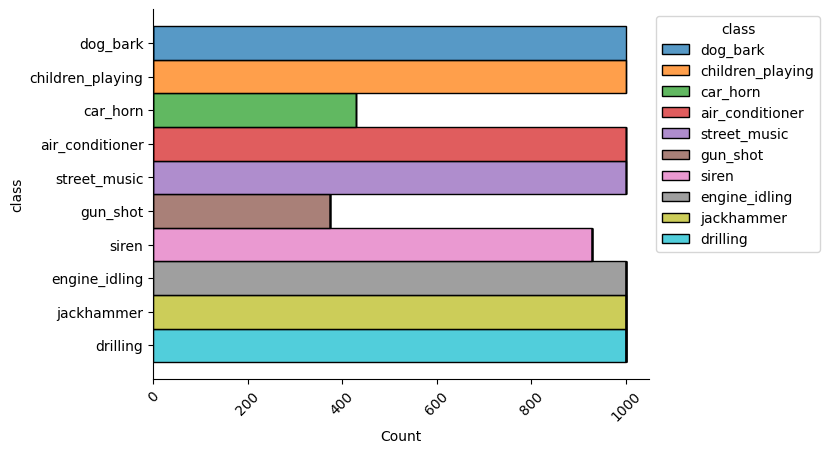

In [17]:
#ver graficamente
ax = sns.histplot(y='class',data = df, hue="class", multiple="stack")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45);
sns.despine()
plt.show()

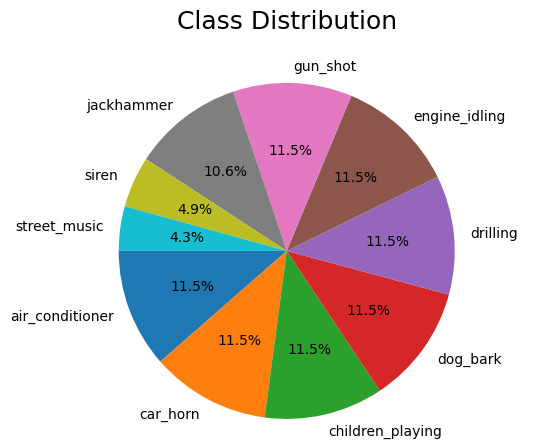

In [18]:
class_dict = df['class'].value_counts(normalize=True)
classes = list(np.unique(df['class']))
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08, fontsize=18)
ax.pie(class_dict, labels=classes, autopct='%1.1f%%', shadow=False, startangle=180)
ax.axis('equal')
plt.savefig("distribution_class")
plt.show(block=False)

### Verificação da existência de diferentes durações

In [19]:
dif1=df['end'].iloc[0]-df['start'].iloc[0]
dif2=df['end'].iloc[1]-df['start'].iloc[1]
print(dif1)
print(dif2)


0.317551
4.0


In [20]:
for index, row in df.iterrows():
    difference = row['end'] - row['start']
    print(f'Difference for row {index}: {difference}')

Difference for row 0: 0.317551
Difference for row 1: 4.0
Difference for row 2: 4.0
Difference for row 3: 4.0
Difference for row 4: 4.0
Difference for row 5: 4.0
Difference for row 6: 4.0
Difference for row 7: 4.0
Difference for row 8: 4.0
Difference for row 9: 0.6485250000000002
Difference for row 10: 1.0538530000000002
Difference for row 11: 0.4053280000000008
Difference for row 12: 1.6213109999999986
Difference for row 13: 1.8645080000000007
Difference for row 14: 4.0
Difference for row 15: 4.0
Difference for row 16: 4.0
Difference for row 17: 4.0
Difference for row 18: 4.0
Difference for row 19: 4.0
Difference for row 20: 4.0
Difference for row 21: 4.0
Difference for row 22: 4.0
Difference for row 23: 4.0
Difference for row 24: 4.0
Difference for row 25: 4.0
Difference for row 26: 4.0
Difference for row 27: 4.0
Difference for row 28: 4.0
Difference for row 29: 4.0
Difference for row 30: 4.0
Difference for row 31: 4.0
Difference for row 32: 4.0
Difference for row 33: 4.0
Difference f

Difference for row 3036: 1.988875000000001
Difference for row 3037: 1.6773640000000007
Difference for row 3038: 1.7013270000000027
Difference for row 3039: 4.0
Difference for row 3040: 4.0
Difference for row 3041: 4.0
Difference for row 3042: 4.0
Difference for row 3043: 4.0
Difference for row 3044: 4.0
Difference for row 3045: 4.0
Difference for row 3046: 4.0
Difference for row 3047: 4.0
Difference for row 3048: 4.0
Difference for row 3049: 4.0
Difference for row 3050: 4.0
Difference for row 3051: 4.0
Difference for row 3052: 0.47302500000000003
Difference for row 3053: 0.7747850000000001
Difference for row 3054: 1.4981790000000001
Difference for row 3055: 0.78669
Difference for row 3056: 0.7461059999999999
Difference for row 3057: 4.0
Difference for row 3058: 4.0
Difference for row 3059: 4.0
Difference for row 3060: 4.0
Difference for row 3061: 4.0
Difference for row 3062: 4.0
Difference for row 3063: 4.0
Difference for row 3064: 4.0
Difference for row 3065: 4.0
Difference for row 30

In [21]:
count=0
for index, row in df.iterrows():
    difference = row['end'] - row['start']
    if difference!=4:
        count+=1
print(count)

1868


**1868 aúdios têm uma duração diferente de 4 segundos.**

In [22]:
#1 audio fold1
#sr = sampling rate -> numero de amostras do som por segundo
audiodata, sr=librosa.load('C:/tmp/sound_datasets/urbansound8k/audio/fold1/7061-6-0-0.wav')
audiodata


array([-7.4505806e-09,  2.9802322e-08,  4.8428774e-08, ...,
        1.0127544e-05,  2.3271263e-05,  7.0009992e-06], dtype=float32)

In [23]:
sr

22050

In [24]:

ipd.Audio('C:/tmp/sound_datasets/urbansound8k/audio/fold1/7061-6-0-0.wav')


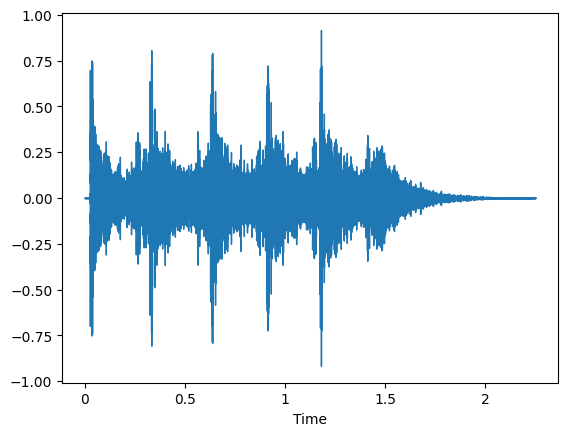

In [25]:
librosa.display.waveshow(audiodata, sr=sr)

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

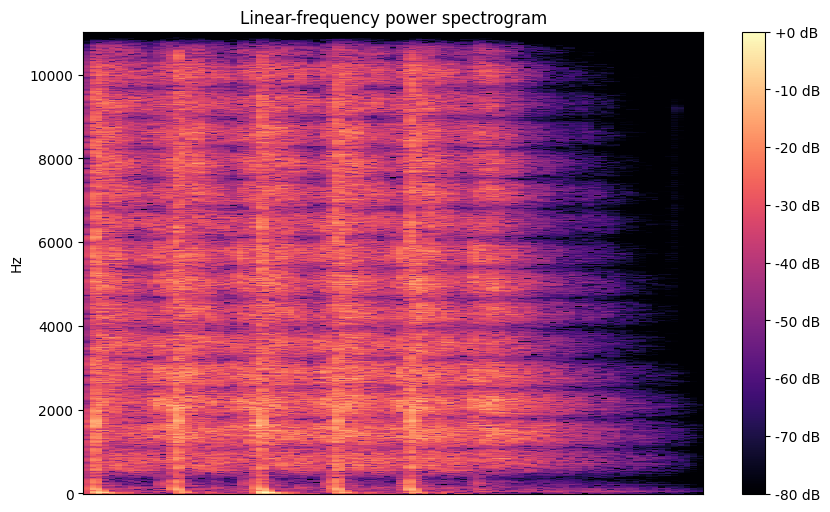

In [26]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(audiodata)), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [27]:
audio_file_path ='C:/tmp/sound_datasets/urbansound8k/audio/fold2/4201-3-0-0.wav'

audiodata2,sr2=librosa.load(audio_file_path)

ipd.Audio(audio_file_path)



In [28]:
sr2

22050

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

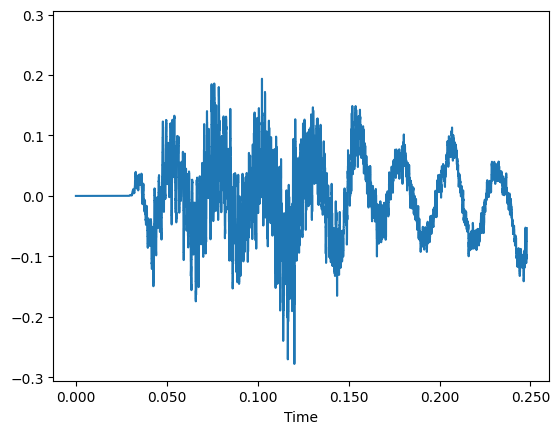

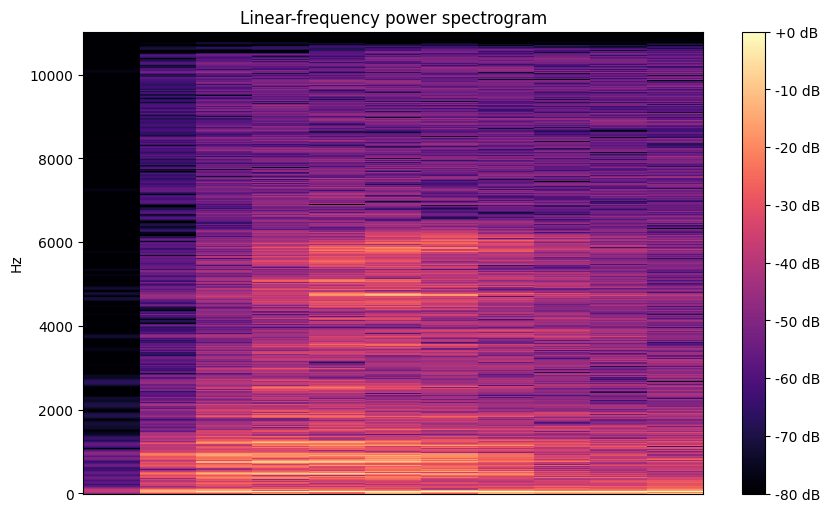

In [29]:
librosa.display.waveshow(audiodata2, sr=sr2)

D = librosa.amplitude_to_db(np.abs(librosa.stft(audiodata2)), ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

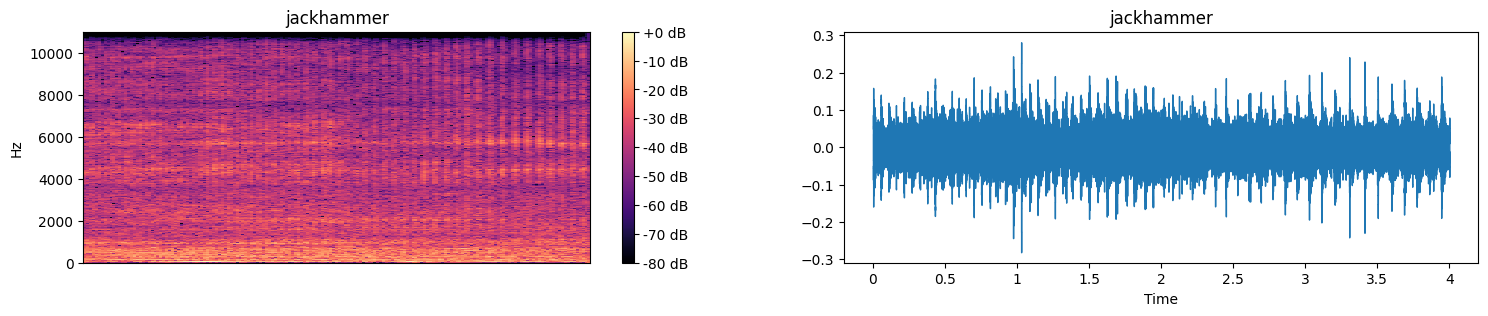

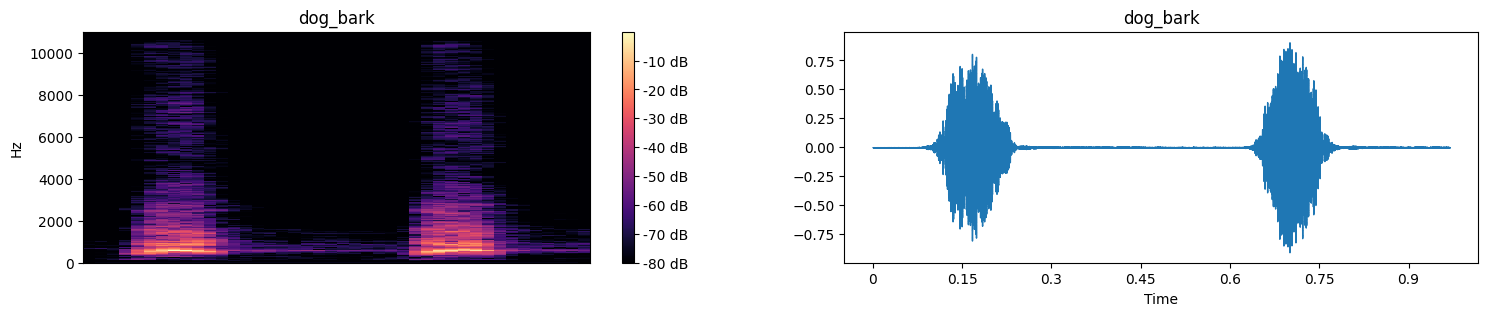

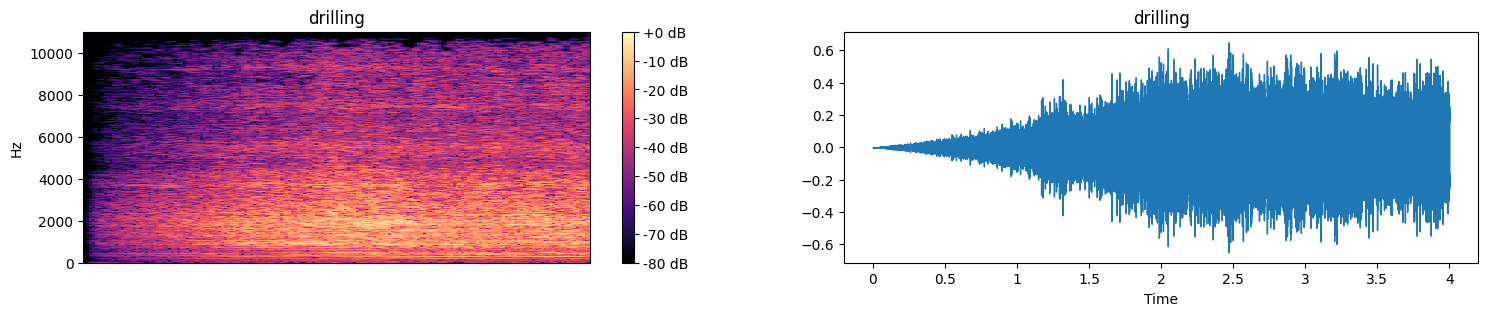

In [33]:
for i in range(192, 197, 2):
    audio_file_path = 'C:/tmp/sound_datasets/urbansound8k/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
    
    audiodata3, sr3 = librosa.load(audio_file_path)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audiodata3)), ref=np.max)
    
    plt.figure(figsize=(18, 3))
    
    plt.subplot(1, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(df["class"][i])
    
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(audiodata3, sr=sr3)
    plt.title(df["class"][i])

### Verificação da existência de diferentes sample rates

In [ ]:
sr_ = set()

from tqdm import tqdm #visualizar os loops

dir="C:/tmp/sound_datasets/urbansound8k/audio/"


for index,row in tqdm(df.iterrows()):
    audio_path=dir+'fold'+ str(row['fold']) + '/' + row['slice_file_name']
    audiodata, sr = librosa.load(audio_path)
    sr_.add(sr)
    
if len(sr_) > 1:
    print("Existem taxas de amostragem diferentes nos arquivos de áudio:")
    for sr in taxas_amostragem_encontradas:
        print(f"- {sr} Hz")
else:
    print("Todos os arquivos de áudio têm a mesma taxa de amostragem.")
    

**Observações:** _Existem áudios com diferentes durações, pelo que iremos preencher os áudios mais curtos até aos 4 segundos._ 

### Extração das Features


In [ ]:
#data -> array, cada elemento do array representa 1 amostra do sinal do audio (amplitude num determinado tempo)
#sr-> numero de amostras por segundo
# 1 segundo - sr, entao total segundos - numero de amostras/sr => len(data)/sr

#preencher os audios mais curtos:
#calcular o tempo que falta ate aos 4 segundos. 1 segundo - sr, x segundos - x*sr => numero de amostras em falta
#(4segundo-tempo atual)*sr => numero de elementos em falta no array

def extracao_features(audio_file, target_duration):
    data, sr =librosa.load(audio_file, res_type='kaiser_fast')
    
    #uniforme duracao
    current_duration=len(data)/sr
    if current_duration < target_duration:
        #calcula nr de zeros
        zeros=int((target_duration - current_duration))*sr
        new_data=np.pad(data,(0,zeros),'constant')#adiciona x zeros no final array
    else: new_data=data
    
    mfccs_file=librosa.feature.mfcc(y=new_data, sr=sr,n_mfcc=40)
    return mfccs_file
    

_Correr o bloco de código seguinte apenas se for a primeira vez a extrair as features._

In [ ]:
from tqdm import tqdm

dir="C:/tmp/sound_datasets/urbansound8k/audio/"
mfccs_audio_data=[]
duration=4.0

for index,row in tqdm(df.iterrows()):
    audio_path=dir+'fold'+ str(row['fold']) + '/' + row['slice_file_name']
    class_label = row['class']
    mfccs_audio = extracao_features(audio_path, duration)
    mfccs_audio = np.mean(mfccs_audio.T,axis=0)
    mfccs_audio_data.append([mfccs_audio, class_label])

df_features=pd.DataFrame(mfccs_audio_data, columns=['features','class'])
df_features.to_csv("./featuredf.csv")

In [10]:
df_features=pd.read_csv("./featuredf.csv")

In [11]:
df_features

,Unnamed: 0,features,class
0,0,[-217.35526 70.22338 -130.38527 -5...,dog_bark
1,1,[-4.2409818e+02 1.0934077e+02 -5.2919525e+01 ...,children_playing
2,2,[-4.5879114e+02 1.2138419e+02 -4.6520660e+01 ...,children_playing
3,3,[-413.89984 101.66373 -35.42945 5...,children_playing
4,4,[-4.4660352e+02 1.1368541e+02 -5.2402206e+01 ...,children_playing
...,...,...,...
8727,8727,[-3.9858450e+02 1.3553496e+02 -5.0725018e+01 ...,car_horn
8728,8728,[-3.4647421e+02 8.6348152e+01 -4.5168579e+01 ...,car_horn
8729,8729,[-3.0388824e+02 1.1135945e+02 -4.5941563e+01 ...,car_horn
8730,8730,[-3.4411008e+02 1.2545021e+02 -5.4903442e+01 ...,car_horn


In [12]:
df_features['features'] = df_features['features'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

In [13]:
X=np.array(df_features['features'].tolist())
y = np.array(df_features['class'].tolist())

In [14]:
print(X.shape)

(8732, 40)


In [15]:
print(y.shape)

(8732,)


### Normalização dos Dados

Após a análise dos dados, em primeiro lugar, estes passam por uma normalização, onde são estruturados em DataFrames para separar as características e target. As classes da target são numericamente codificadas com o LabelEncoder e transformadas em vetores binários e o conjunto de dados é dividido em conjuntos de treino e teste para avaliação do modelo.

In [16]:
scaler = StandardScaler()
features_nom = scaler.fit_transform(X)

In [17]:
features=pd.DataFrame(features_nom)
target=pd.DataFrame(y, columns = ['class'])

In [18]:
df2 = pd.concat([features, target], axis = 1)

In [19]:
df2

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,class
0,0.098916,-0.918738,-3.274024,-3.384654,-0.522299,-2.529374,-0.221542,0.603220,1.535350,0.555272,...,1.684273,0.183173,0.352386,-1.364543,-1.033254,1.310010,-0.271654,0.122490,0.055830,dog_bark
1,-1.495096,-0.103775,-0.805139,1.859902,0.841593,0.197031,0.740088,-0.075659,0.772967,0.322871,...,0.369684,0.023162,-0.109625,0.344846,-0.080892,-0.197082,0.256732,0.143060,0.070201,children_playing
2,-1.762583,0.147135,-0.601203,1.452981,0.825968,0.635470,1.234153,-0.224349,0.845139,0.170070,...,-0.431972,-0.670958,-0.728563,-0.106879,-0.644829,-0.141766,0.622426,0.780680,-0.265206,children_playing
3,-1.416466,-0.263717,-0.247719,1.500224,0.922680,0.029419,0.798234,-0.351612,0.695618,0.046998,...,0.195551,0.440769,0.161072,-0.346508,0.316356,-0.133630,-0.180521,-0.298959,-0.320465,children_playing
4,-1.668615,-0.013260,-0.788652,1.834049,1.002767,0.723343,0.792641,-0.126635,1.192780,0.104611,...,-0.433446,0.161510,0.380995,-0.280189,-0.042976,0.088588,0.623016,0.615609,-0.025724,children_playing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,-1.298383,0.441949,-0.735199,0.710862,0.314664,0.044630,1.150217,0.471190,0.424347,-0.682544,...,0.548043,1.184698,0.701537,0.326256,0.448425,-1.089218,-1.549287,-0.403168,0.925310,car_horn
8728,-0.896606,-0.582798,-0.558111,1.439278,-1.241437,-1.278421,1.982010,-1.079748,-0.422786,1.325508,...,0.658679,0.284021,1.661612,1.742777,0.152656,-0.195180,0.752949,-0.317627,-0.723824,car_horn
8729,-0.568263,-0.061718,-0.582747,0.711832,0.245286,-0.125330,0.787198,-0.140999,0.238266,-0.459069,...,-0.102059,1.161072,1.716377,1.362998,0.570475,-0.870050,-0.588547,1.071106,1.779342,car_horn
8730,-0.878379,0.231846,-0.868368,0.666536,-0.422299,-0.483782,1.584711,-0.216241,0.084107,1.018208,...,0.507098,1.581485,1.545796,0.837310,0.879758,-1.067209,-1.745665,-0.169001,1.314044,car_horn


In [20]:
X = df2.iloc[:, :-1].values
y = df2.iloc[:, -1].values.reshape(-1,1)

In [21]:
X.shape

(8732, 40)

In [22]:
y.shape

(8732, 1)

In [23]:
y

array([['dog_bark'],
       ['children_playing'],
       ['children_playing'],
       ...,
       ['car_horn'],
       ['car_horn'],
       ['car_horn']], dtype=object)

In [135]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y = to_categorical(y_encoded)

In [25]:
y.shape

(8732, 10)

In [26]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [27]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [28]:
print(X_train4.shape, y_train4.shape)
print(X_test4.shape, y_test4.shape)

(6985, 40) (6985, 10)
(1747, 40) (1747, 10)


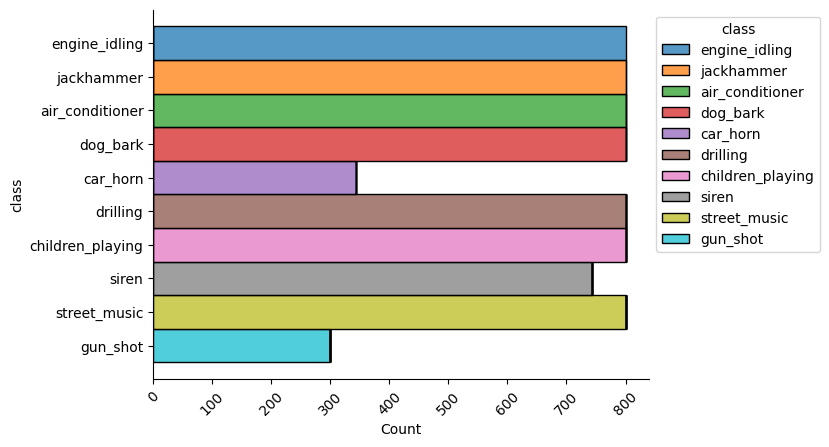

In [33]:
X2 = df2.drop('class', axis=1)  
y2 = df2['class']

#desbalanceamento
#statify para garantir as proporções
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42,stratify=y2)

df_train = pd.DataFrame(data=X_train, columns=df2.columns[:-1]) 


df_train['class'] = y_train

#gráfico
ax = sns.histplot(y='class', data=df_train, hue="class", multiple="stack")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
sns.despine()
plt.show()


In [34]:
#distribuição das classes
class_dict = y_train.value_counts(normalize=True)
print(class_dict)

engine_idling       0.114531
jackhammer          0.114531
air_conditioner     0.114531
dog_bark            0.114531
drilling            0.114531
children_playing    0.114531
street_music        0.114531
siren               0.106371
car_horn            0.049105
gun_shot            0.042806
Name: class, dtype: float64


### Oversampling duplicando classes até 1000

Como demonstrado nos gráficos acima, observa-se uma inicial disparidade no número de amostras entre as classes no conjunto de dados original. Assim, adotou-se uma estratégia para equilibrar essas discrepâncias, realizando duplicados (até 1000 amostras) e, se necessário, a seleção aleatória de amostras para atingir esse limite. O resultado é um conjunto de dados equilibrado.

Posteriormente, esta abordagem é aplicada aos conjuntos de treino e, novamente, as classes são codificadas numericamente e transformadas em vetores binários.

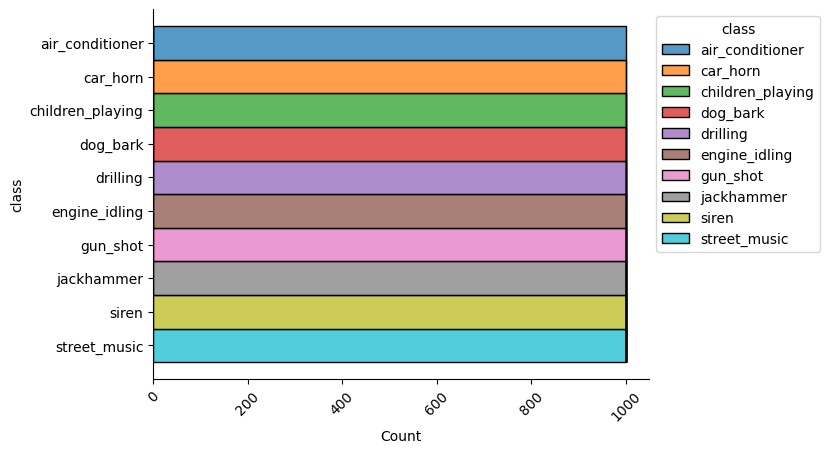

In [35]:
max_samples = 1000

# lista dados balanceados
balanced_dfs = []

# ver cada classe
for label, group in df2.groupby('class'):
    current_samples = len(group) # amostras da classe

    # numero de duplicadas para 1000 amostras
    duplications_needed = max_samples // current_samples

    # duplicar a classe
    balanced_dfs.append(pd.concat([group] * duplications_needed, ignore_index=True))

    # amostras extras se necessario
    remaining_samples = max_samples % current_samples
    if remaining_samples > 0:
        balanced_dfs.append(group.sample(remaining_samples, replace=True))

balanced_data = pd.concat(balanced_dfs, ignore_index=True)

#gráfico
ax = sns.histplot(y='class', data=balanced_data, hue="class", multiple="stack")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
sns.despine()
plt.show()

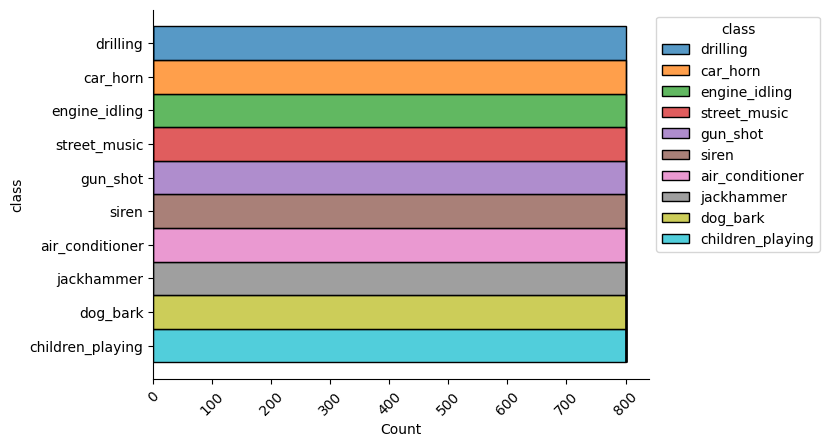

In [36]:
X3 = balanced_data.drop('class', axis=1)  
y3 = balanced_data['class']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X3, y3, test_size=0.2, random_state=42,stratify=y3)

df_train2 = pd.DataFrame(data=X_train2, columns=balanced_data.columns[:-1]) 


df_train2['class'] = y_train2

#gráfico
ax = sns.histplot(y='class', data=df_train2, hue="class", multiple="stack")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
sns.despine()
plt.show()

In [37]:
# para o CNN
X4 = balanced_data.iloc[:, :-1].values
y4 = balanced_data.iloc[:, -1].values.reshape(-1,1)

In [38]:
print(X4.shape , y4.shape)

(10000, 40) (10000, 1)


In [39]:
y4

array([['air_conditioner'],
       ['air_conditioner'],
       ['air_conditioner'],
       ...,
       ['street_music'],
       ['street_music'],
       ['street_music']], dtype=object)

In [136]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y4)
y4 = to_categorical(y_encoded)

In [41]:
y4

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [42]:
y4.shape

(10000, 10)

In [43]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=42,stratify=y4)

In [44]:
print(X_train4.shape, y_train4.shape)
print(X_test4.shape, y_test4.shape)

(8000, 40) (8000, 10)
(2000, 40) (2000, 10)


### Multilayer Percepton

Multilayer Percepton (MLP) é uma extensão das redes neuronais feedforward, composto por três tipos de camadas: input, hidden layer(s) e output. Na camada de input, o sinal a ser processado é recebido, enquanto a camada de output executa a tarefa desejada, como classificação (como o problema de urban sound) ou previsão. As hidden layers, localizadas entre o input e output, são o verdadeiro mecanismo de cálculo do MLP. Assim como em redes feedforward, os dados fluem do input para o output. O treino dos neurónios no MLP é realizado com o algoritmo de retropropagação (back propagation), capaz de aproximar qualquer função contínua e resolver problemas não linearmente separáveis. O MLP é usado principalmente em problemas de classificação de padrões, reconhecimento, previsão e aproximação.

A obtenção de um desempenho ótimo num modelo MLP envolve a sintonia cuidadosa dos seus hiperparâmetros. Para facilitar este processo, utilizou-se a técnica da procura em grade (GridSearchCV), que explora diversas combinações de hiperparâmetros para identificar aquelas que maximizam o desempenho do modelo.

Inicialmente, tentou-se abordar a otimização de todos os hiperparâmetros simultaneamente, visando simplificar o processo e obter os melhores resultados possíveis. No entanto, esta estratégia não se tornou viável devido à considerável carga computacional envolvida. A tentativa de otimização conjunta resultou em tempos de execução prolongados e recursos computacionais substanciais, tornando-se impraticável.

Perante este cenário, a abordagem foi reconsiderada e optou-se por uma estratégia mais repartida. A segmentação dos conjuntos de hiperparâmetros, abordando cada um de forma isolada, revelou-se uma solução mais eficaz, diminuindo a carga computacional e acelarando significativamente o tempo de execução do processo de otimização.

Assim, os blocos de código seguintes utilizam a biblioteca scikit-learn para realizar essa pesquisa para um MLP. A estratégia envolve a avaliação de diferentes configurações para o número e tamanho de camadas ocultas (1); funções de ativação (2); otimizadores e necessidade de realizar _early stopping_ (3); regularização L2 e taxa de aprendizagem inicial (4); concluindo com número máximo de iterações e tamanho do lote (5).

#### 1. Escolha do numero de layers e neuronios por layer

In [45]:
# dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

# parametros a testar
param_grid = {
    'hidden_layer_sizes': [
        (50,),                  # Uma camada com 50 neurônios
        (50, 30),               # Duas camadas: 50 neurônios na primeira, 30 na segunda
        (30, 20),               # Duas camadas: 30 neurônios na primeira, 20 na segunda
        (50, 50),               # Duas camadas: 50 neurônios em ambas as camadas
        (100, 50, 20),          # Três camadas: 100 neurônios na primeira, 50 na segunda, 20 na terceira
        (100, 100, 50, 20),     # Quatro camadas: 100 neurônios nas duas primeiras, 50 na terceira, 20 na quarta
    ],}

# criar o modelo MLP
mlp = MLPClassifier(random_state=42)

# criar o objeto GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=10, scoring='accuracy')

# procura por grade
grid_search.fit(X_train, y_train)

C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=10, estimator=MLPClassifier(random_state=42),
             param_grid={'hidden_layer_sizes': [(50,), (50, 30), (30, 20),
                                                (50, 50), (100, 50, 20),
                                                (100, 100, 50, 20)]},
             scoring='accuracy')

In [46]:
# obter o melhor numero de camadas e neuróneos por camada
melhor_camada= grid_search.best_params_
print(f'Melhor camada: {melhor_camada}')

Melhor camada: {'hidden_layer_sizes': (100, 100, 50, 20)}


#### 2. Escolha da função de ativação

In [47]:
# parametros a testar
param_grid = {
    'hidden_layer_sizes': [melhor_camada['hidden_layer_sizes'],], # Melhor camada encontrada anteriormente
    'activation': ['relu', 'tanh', 'logistic', 'identity'], # funçoes de ativação
}

# criar o modelo MLP
mlp = MLPClassifier(random_state=42)

# criar o objeto GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=10, scoring='accuracy')

# procura por grade
grid_search.fit(X_train, y_train)

C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multi

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=42),
             param_grid={'activation': ['relu', 'tanh', 'logistic', 'identity'],
                         'hidden_layer_sizes': [(100, 100, 50, 20)]},
             scoring='accuracy')

In [48]:
# obter a melhor função de ativação
melhor_ativacao = grid_search.best_params_['activation']
print(f'Melhor função de ativação: {melhor_ativacao}')

Melhor função de ativação: tanh


#### 3. Escolha dos otimizadores, com/sem early stopping

In [49]:
# Parametros a testar
param_grid = {
    'hidden_layer_sizes': [melhor_camada['hidden_layer_sizes'],], # Melhor camada encontrada anteriormente
    'activation': [melhor_ativacao], # funcoes de ativação
    'solver': ['lbfgs', 'sgd', 'adam'],  # Otimizadores
    'early_stopping': [True, False],  # Early stopping
}

# criar o modelo MLP
mlp = MLPClassifier(random_state=42)

# criar o objeto GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=10, scoring='accuracy')

# procura por grade
grid_search.fit(X_train, y_train)

C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multi

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=42),
             param_grid={'activation': ['tanh'],
                         'early_stopping': [True, False],
                         'hidden_layer_sizes': [(100, 100, 50, 20)],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='accuracy')

In [50]:
# Obter o melhor otimizador 
melhor_otimizador = grid_search.best_params_['solver']
print(f'Melhor otimizador: {melhor_otimizador}')

# Com ou sem early stoping?
early_stop = grid_search.best_params_['early_stopping']
print(f'Usar early stopping?: {early_stop}')

Melhor otimizador: adam
Usar early stopping?: False


#### 4. Escolha da Regularização e taxa de aprendizagem inicial

In [127]:
# Parametros a testar
param_grid = {
    'hidden_layer_sizes': [melhor_camada['hidden_layer_sizes'],], # Melhor camada encontrada anteriormente
    'activation': [melhor_ativacao], # funcoes de ativação
    'solver': [melhor_otimizador],  # Otimizadores
    'early_stopping': [early_stop],  # Early stopping
    'alpha': [0.0001, 0.001, 0.01],  # Regularização L2
    'learning_rate_init': [0.001, 0.01, 0.1],  # Taxa de aprendizagem inicial
}

# criar o modelo MLP
mlp = MLPClassifier(random_state=42)

# criar o objeto GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=10, scoring='accuracy')

#procura por grade
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=42),
             param_grid={'activation': ['tanh'], 'alpha': [0.0001, 0.001, 0.01],
                         'early_stopping': [False],
                         'hidden_layer_sizes': [(100, 100, 50, 20)],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'solver': ['adam']},
             scoring='f1_micro')

In [128]:
# melhor regularização 
melhor_alpha = grid_search.best_params_['alpha']
print(f'Melhor alpha: {melhor_alpha}')

# melhor taxa de aprendizagem
melhor_taxa = grid_search.best_params_['learning_rate_init']
print(f'Melhor taxa de aprendizagem: {melhor_taxa}')

Melhor alpha: 0.0001
Melhor taxa de aprendizagem: 0.001


#### 5. Escolha do numero máximo de iterações e tamanho do lote

In [53]:
# Parametros a testar
param_grid = {
    'hidden_layer_sizes': [melhor_camada['hidden_layer_sizes'],], # Melhor camada encontrada anteriormente
    'activation': [melhor_ativacao], # funções de ativação
    'solver': [melhor_otimizador],  # Otimizadores
    'early_stopping': [early_stop],  # Early stopping
    'alpha': [melhor_alpha],  # Regularização L2
    'learning_rate_init': [melhor_taxa],  # Taxa de aprendizagem inicial
    'max_iter': [500, 1000, 1500],
    'batch_size': [32, 64, 128],  # Tamanho do lote
}

# criar o modelo MLP
mlp = MLPClassifier(random_state=42)

# criar o objeto GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=10, scoring='accuracy')

# procura por grade
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=42),
             param_grid={'activation': ['tanh'], 'alpha': [0.0001],
                         'batch_size': [32, 64, 128], 'early_stopping': [False],
                         'hidden_layer_sizes': [(100, 100, 50, 20)],
                         'learning_rate_init': [0.001],
                         'max_iter': [500, 1000, 1500], 'solver': ['adam']},
             scoring='accuracy')

In [ ]:
# melhor numero maximo de iterações
melhor_iter = grid_search.best_params_['max_iter']
print(f'Melhor número máximo de iterações: {melhor_iter}')

# melhor tamanho do lote
melhor_tamanho_lote = grid_search.best_params_['batch_size']
print(f'Melhor tamanho do lote: {melhor_tamanho_lote}')

Melhor número máximo de iterações: 500
Melhor tamanho do lote: 64


### Melhores parâmetros

In [55]:
# os melhores parametros gerais
melhores_parametros= grid_search.best_params_
print(f'Melhores parametros: {melhores_parametros}')

Melhores parametros: {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 64, 'early_stopping': False, 'hidden_layer_sizes': (100, 100, 50, 20), 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'adam'}


O conjunto de parâmetros escolhido após a execução do GridSearchCV para a classificação de sons urbanos por meio de uma MLP pode ser explicado considerando diversos fatores. Em primeiro lugar, a função de ativação 'tanh' foi selecionada, possivelmente devido à sua capacidade de capturar padrões mais complexos em comparação com outras funções, como 'logistic' ou 'identity'. A regularização L2, representada pelo parâmetro 'alpha', foi configurada para um valor de 0.0001, indicando uma pequena penalização para evitar overfitting nos dados de treino.

O tamanho do lote ('batch_size') foi fixado em 64, uma escolha que pode ter sido feita com vista à eficiência computacional e para suavizar as atualizações de pesos durante o treino. A opção de não utilizar 'early_stopping' sugere que o modelo não está propenso a overfitting durante as primeiras iterações, uma conclusão que pode ser derivada do desempenho consistente no conjunto de validação.

Quanto à arquitetura da rede neural ('hidden_layer_sizes'), a escolha de quatro camadas ocultas com tamanhos (100, 100, 50, 20) pode indicar a busca por uma capacidade maior de capturar padrões complexos nos dados. A taxa de aprendizagem inicial ('learning_rate_init') de 0.001 foi considerada suficientemente pequena para garantir uma convergência suave durante o treino, evitando oscilações ou convergência lenta.

O otimizador 'Adam' foi selecionado, sendo uma escolha adaptativa eficiente para diversos conjuntos de dados. Quanto ao número máximo de iterações ('max_iter'), fixado em 500, pode ser interpretado como um ponto de convergência adequado nos dados de treinamento, evitando um aumento desnecessário no tempo de treino. Estas escolhas refletem a otimização do desempenho do modelo em termos de accuracy com base na natureza específica do conjunto de dados de sons urbanos.

### Resultados com os melhores parâmetros

In [148]:
# Criar o modelo com os melhores parâmetros
best_model = grid_search.best_estimator_

# Criar um objeto StratifiedKFold para preservar a distribuição das classes durante a divisão
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Avaliar o modelo 
cv_results = cross_validate(best_model, X3, y3, cv=stratified_kfold, return_train_score=True)

train_accuracy = cv_results['train_score']
test_accuracy = cv_results['test_score']

mean_train_accuracy = np.mean(train_accuracy)
std_train_accuracy = np.std(train_accuracy)
mean_test_accuracy = np.mean(test_accuracy)
std_test_accuracy = np.std(test_accuracy)

print(f'Média da accuracy de treino: {mean_train_accuracy}')
print(f'Desvio padrão da accuracy de treino: {std_train_accuracy}')
print()
print(f'Média da accuracy de teste: {mean_test_accuracy}')
print(f'Desvio padrão da accuracy de teste: {std_test_accuracy}')

Média da accuracy de treino: 0.9984444444444444
Desvio padrão da accuracy de treino: 0.0003022549001941339

Média da accuracy de teste: 0.9271
Desvio padrão da accuracy de teste: 0.0089269255625887


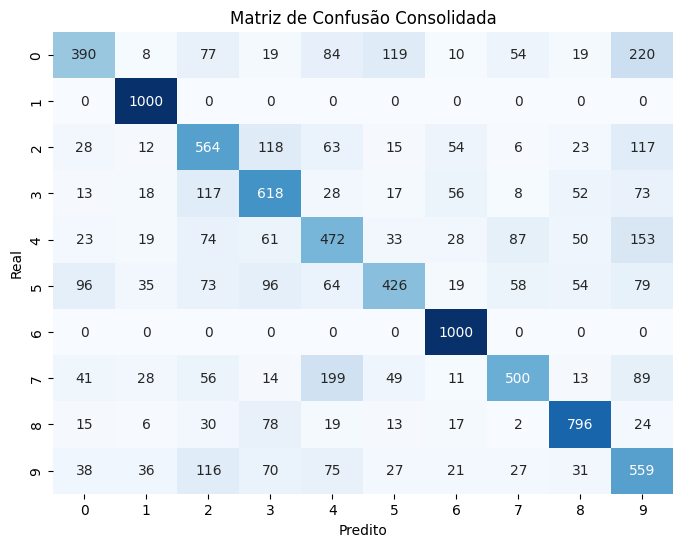

In [142]:
# Previsoes 
y_test_pred = cross_val_predict(grid_search.best_estimator_, X3, y3, cv=10)

# Matriz de confusao
conf_matrix_test = confusion_matrix(y3, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão Consolidada')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

Após a avaliação do modelo de Perceptron Multicamadas (MLP) com os parâmetros otimizados usando 10-fold cross-validation, os resultados indicam um desempenho consistente e eficaz.

Os resultados da validação cruzada para o modelo de Perceptron Multicamadas (MLP) revelam insights valiosos sobre o seu desempenho. O modelo, treinado com os melhores parâmetros, demonstra uma notável capacidade de se ajustar aos dados de treino, refletido pela alta média de accuracy de treino, que atinge aproximadamente 99,84%. No entanto, a diferença entre a accuracy de treino e teste é relativamente pequena, indicando que o modelo não está a sofrer de overfitting excessivo, o que é uma característica positiva.

A média da accuracy de teste, em torno de 92,71%, sugere que o modelo é capaz de fazer previsões precisas em conjuntos de dados não vistos, apontando para um desempenho geral sólido. Além disso, a baixa variação na accuracy de treino indica consistência no desempenho do modelo nos dados de treino, enquanto a variação na de teste, embora presente, é relativamente baixa, indicando robustez em diferentes conjuntos de dados de teste.

Em resumo, os resultados sugerem que o modelo MLP está bem ajustado aos dados, generaliza eficazmente para dados não vistos e apresenta uma performance equilibrada.

### Convolutional Neural Network - 1D

As Redes Neurais Convolucionais Unidimensionais (CNN1D) são uma variação das arquiteturas de redes neurais convolucionais, projetadas especificamente para processar dados sequenciais unidimensionais, como séries temporais, sinais de áudio ou sequências de texto. Assim como as CNNs tradicionais, as CNN1D são conhecidas por sua capacidade de extrair padrões importantes automaticamente, reduzindo a necessidade de pré-processamento manual de recursos.


A arquitetura de uma CNN1D compreende camadas convolucionais, camadas de pooling e camadas totalmente conectadas.
As camadas convolucionais aplicam filtros ao longo da dimensão da sequência, capturando padrões locais nas entradas. Cada filtro detecta características específicas, permitindo à rede aprender representações hierárquicas de diferentes níveis de abstração.
Após as camadas convolucionais, as camadas de pooling são usadas para reduzir a dimensionalidade da representação e focar nas características mais relevantes.
A camada de "Flatten" é usada para transformar a saída das camadas convolucionais e de pooling num vetor unidimensional.
Após a extração de características, as camadas totalmente conectadas são usadas para realizar a classificação final. Essas camadas combinam as características aprendidas para fazer previsões sobre as classes.
A técnica de Dropout é comumente aplicada para prevenir o overfitting, desligando aleatoriamente neurónios durante o treino.


A opção pela CNN1D, e não de uma CNN2D, foi devido à natureza unidimensional dos dados em questão.

A construção da arquitetura da CNN1D foi um processo iterativo, envolvendo múltiplas tentativas para otimizar o desempenho do modelo. Foram realizadas várias experiências, variando o número de camadas convolucionais, unidades em cada camada e estruturas de camadas totalmente conectadas.

A escolha final da arquitetura resultou de uma análise dos resultados obtidos em diferentes configurações.


In [65]:
def cnn1d():
    # dimensoes entrada
    input_shape = (40, 1)

    # modelo
    model = Sequential()

    # ativacao ReLU
    model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=input_shape))
    # para reduzir a dimensionalidade
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # segunda camada
    model.add(Conv1D(256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # formato para a camada densa
    model.add(Flatten())

    # 1camada densa regularizacao l2
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0001)))
    # Dropout
    model.add(Dropout(0.2))

    # 2 camada densa 
    model.add(Dense(128, activation='relu'))
    # Dropout
    model.add(Dropout(0.2))

    # 3 camada densa com mais neurônios
    model.add(Dense(64, activation='relu'))
    # Dropout
    model.add(Dropout(0.2))

    # camada densa final com ativacao softmax -> multiclasse
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision'])
    
    return model


In [66]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

all_train_accuracies = []
all_test_accuracies = []
all_confusion_matrices = []

# 9 folds treino 1 teste
for train_idx, val_idx in kfold.split(X4, np.argmax(y4, axis=1)):
    x_train_fold, y_train_fold = X4[train_idx], y4[train_idx]
    x_val_fold, y_val_fold = X4[val_idx], y4[val_idx]

    #reiniciar
    model = cnn1d()

    # treinar
    history = model.fit(x_train_fold.reshape(x_train_fold.shape[0], x_train_fold.shape[1], 1), y_train_fold, epochs=50, batch_size=32, validation_data=(x_val_fold.reshape(x_val_fold.shape[0], x_val_fold.shape[1], 1), y_val_fold))

    #Avaliar
    y_train_pred_prob = model.predict(x_train_fold.reshape(x_train_fold.shape[0], x_train_fold.shape[1], 1))
    y_train_pred = np.argmax(y_train_pred_prob, axis=1)

    train_accuracy = accuracy_score(np.argmax(y_train_fold, axis=1), y_train_pred)
    all_train_accuracies.append(train_accuracy)

    # Avaliar no teste
    y_test_pred_prob = model.predict(x_val_fold.reshape(x_val_fold.shape[0], x_val_fold.shape[1], 1))
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)

    test_accuracy = accuracy_score(np.argmax(y_val_fold, axis=1), y_test_pred)
    all_test_accuracies.append(test_accuracy)

    #matriz de confusao do teste
    cm = confusion_matrix(np.argmax(y_val_fold, axis=1), y_test_pred)
    all_confusion_matrices.append(cm)




Epoch 1/50
282/282 [==============================] - 15s 29ms/step - loss: 1.7267 - accuracy: 0.4001 - precision: 0.7495 - val_loss: 1.0964 - val_accuracy: 0.6350 - val_precision: 0.8865
Epoch 2/50
282/282 [==============================] - 8s 29ms/step - loss: 1.0684 - accuracy: 0.6601 - precision: 0.8133 - val_loss: 0.7079 - val_accuracy: 0.7740 - val_precision: 0.8785
Epoch 3/50
282/282 [==============================] - 8s 28ms/step - loss: 0.8003 - accuracy: 0.7502 - precision: 0.8503 - val_loss: 0.5134 - val_accuracy: 0.8450 - val_precision: 0.8978
Epoch 4/50
282/282 [==============================] - 8s 28ms/step - loss: 0.6451 - accuracy: 0.8086 - precision: 0.8765 - val_loss: 0.4427 - val_accuracy: 0.8720 - val_precision: 0.9312
Epoch 5/50
282/282 [==============================] - 8s 28ms/step - loss: 0.5481 - accuracy: 0.8450 - precision: 0.8966 - val_loss: 0.4044 - val_accuracy: 0.8900 - val_precision: 0.9242
Epoch 6/50
282/282 [==============================] - 8s 29ms/st

Epoch 45/50
282/282 [==============================] - 7s 27ms/step - loss: 0.2214 - accuracy: 0.9739 - precision: 0.9766 - val_loss: 0.3546 - val_accuracy: 0.9410 - val_precision: 0.9514
Epoch 46/50
282/282 [==============================] - 7s 25ms/step - loss: 0.2220 - accuracy: 0.9757 - precision: 0.9787 - val_loss: 0.3286 - val_accuracy: 0.9500 - val_precision: 0.9545
Epoch 47/50
282/282 [==============================] - 7s 26ms/step - loss: 0.2285 - accuracy: 0.9736 - precision: 0.9768 - val_loss: 0.3403 - val_accuracy: 0.9500 - val_precision: 0.9517
Epoch 48/50
282/282 [==============================] - 8s 27ms/step - loss: 0.2134 - accuracy: 0.9769 - precision: 0.9796 - val_loss: 0.3322 - val_accuracy: 0.9490 - val_precision: 0.9537
Epoch 49/50
282/282 [==============================] - 7s 26ms/step - loss: 0.2115 - accuracy: 0.9773 - precision: 0.9805 - val_loss: 0.3700 - val_accuracy: 0.9520 - val_precision: 0.9567
Epoch 50/50
32/32 [==============================] - 0s 4ms/

282/282 [==============================] - 7s 26ms/step - loss: 0.2147 - accuracy: 0.9808 - precision: 0.9826 - val_loss: 0.4221 - val_accuracy: 0.9240 - val_precision: 0.9284
Epoch 39/50
282/282 [==============================] - 7s 26ms/step - loss: 0.2067 - accuracy: 0.9830 - precision: 0.9849 - val_loss: 0.4359 - val_accuracy: 0.9230 - val_precision: 0.9284
Epoch 40/50
282/282 [==============================] - 7s 26ms/step - loss: 0.2237 - accuracy: 0.9747 - precision: 0.9777 - val_loss: 0.4935 - val_accuracy: 0.9170 - val_precision: 0.9203
Epoch 41/50
282/282 [==============================] - 7s 26ms/step - loss: 0.2255 - accuracy: 0.9757 - precision: 0.9773 - val_loss: 0.4274 - val_accuracy: 0.9320 - val_precision: 0.9328
Epoch 42/50
282/282 [==============================] - 8s 27ms/step - loss: 0.2119 - accuracy: 0.9797 - precision: 0.9816 - val_loss: 0.4501 - val_accuracy: 0.9140 - val_precision: 0.9228
Epoch 43/50
282/282 [==============================] - 8s 27ms/step - lo

282/282 [==============================] - 8s 29ms/step - loss: 0.2352 - accuracy: 0.9686 - precision: 0.9731 - val_loss: 0.3991 - val_accuracy: 0.9220 - val_precision: 0.9348
Epoch 25/50
282/282 [==============================] - 8s 30ms/step - loss: 0.2285 - accuracy: 0.9696 - precision: 0.9736 - val_loss: 0.3982 - val_accuracy: 0.9240 - val_precision: 0.9298
Epoch 26/50
282/282 [==============================] - 8s 27ms/step - loss: 0.2394 - accuracy: 0.9682 - precision: 0.9719 - val_loss: 0.3582 - val_accuracy: 0.9320 - val_precision: 0.9383
Epoch 27/50
282/282 [==============================] - 9s 31ms/step - loss: 0.2307 - accuracy: 0.9703 - precision: 0.9737 - val_loss: 0.4176 - val_accuracy: 0.9270 - val_precision: 0.9340
Epoch 28/50
282/282 [==============================] - 9s 30ms/step - loss: 0.2298 - accuracy: 0.9708 - precision: 0.9748 - val_loss: 0.3980 - val_accuracy: 0.9240 - val_precision: 0.9358
Epoch 29/50
282/282 [==============================] - 8s 30ms/step - lo

282/282 [==============================] - 9s 31ms/step - loss: 0.3375 - accuracy: 0.9231 - precision: 0.9410 - val_loss: 0.4741 - val_accuracy: 0.8910 - val_precision: 0.9143
Epoch 11/50
282/282 [==============================] - 8s 30ms/step - loss: 0.3033 - accuracy: 0.9366 - precision: 0.9482 - val_loss: 0.4431 - val_accuracy: 0.9090 - val_precision: 0.9197
Epoch 12/50
282/282 [==============================] - 9s 34ms/step - loss: 0.2965 - accuracy: 0.9396 - precision: 0.9523 - val_loss: 0.4202 - val_accuracy: 0.9210 - val_precision: 0.9316
Epoch 13/50
282/282 [==============================] - 9s 31ms/step - loss: 0.2899 - accuracy: 0.9418 - precision: 0.9532 - val_loss: 0.4020 - val_accuracy: 0.9200 - val_precision: 0.9289
Epoch 14/50
282/282 [==============================] - 9s 31ms/step - loss: 0.2553 - accuracy: 0.9543 - precision: 0.9634 - val_loss: 0.4419 - val_accuracy: 0.9090 - val_precision: 0.9205
Epoch 15/50
282/282 [==============================] - 9s 32ms/step - lo

Epoch 47/50
282/282 [==============================] - 7s 25ms/step - loss: 0.2227 - accuracy: 0.9780 - precision: 0.9807 - val_loss: 0.4248 - val_accuracy: 0.9380 - val_precision: 0.9396
Epoch 48/50
282/282 [==============================] - 7s 25ms/step - loss: 0.2147 - accuracy: 0.9782 - precision: 0.9806 - val_loss: 0.4040 - val_accuracy: 0.9370 - val_precision: 0.9424
Epoch 49/50
282/282 [==============================] - 8s 28ms/step - loss: 0.2038 - accuracy: 0.9819 - precision: 0.9840 - val_loss: 0.4647 - val_accuracy: 0.9220 - val_precision: 0.9284
Epoch 50/50
32/32 [==============================] - 0s 8ms/step
Epoch 1/50
282/282 [==============================] - 10s 28ms/step - loss: 1.7155 - accuracy: 0.4029 - precision: 0.7409 - val_loss: 1.1590 - val_accuracy: 0.6350 - val_precision: 0.9044
Epoch 2/50
282/282 [==============================] - 7s 26ms/step - loss: 1.0897 - accuracy: 0.6467 - precision: 0.8086 - val_loss: 0.8235 - val_accuracy: 0.7340 - val_precision: 0.8

282/282 [==============================] - 7s 24ms/step - loss: 0.2069 - accuracy: 0.9776 - precision: 0.9796 - val_loss: 0.4512 - val_accuracy: 0.9280 - val_precision: 0.9304
Epoch 41/50
282/282 [==============================] - 7s 25ms/step - loss: 0.2236 - accuracy: 0.9716 - precision: 0.9752 - val_loss: 0.4350 - val_accuracy: 0.9300 - val_precision: 0.9382
Epoch 42/50
282/282 [==============================] - 7s 25ms/step - loss: 0.2054 - accuracy: 0.9772 - precision: 0.9805 - val_loss: 0.4803 - val_accuracy: 0.9270 - val_precision: 0.9286
Epoch 43/50
282/282 [==============================] - 7s 26ms/step - loss: 0.2286 - accuracy: 0.9723 - precision: 0.9753 - val_loss: 0.4697 - val_accuracy: 0.9210 - val_precision: 0.9272
Epoch 44/50
282/282 [==============================] - 7s 25ms/step - loss: 0.2063 - accuracy: 0.9797 - precision: 0.9822 - val_loss: 0.4406 - val_accuracy: 0.9240 - val_precision: 0.9320
Epoch 45/50
282/282 [==============================] - 7s 25ms/step - lo

282/282 [==============================] - 8s 28ms/step - loss: 0.2205 - accuracy: 0.9721 - precision: 0.9747 - val_loss: 0.3888 - val_accuracy: 0.9340 - val_precision: 0.9432
Epoch 27/50
282/282 [==============================] - 7s 27ms/step - loss: 0.2113 - accuracy: 0.9724 - precision: 0.9756 - val_loss: 0.4106 - val_accuracy: 0.9280 - val_precision: 0.9353
Epoch 28/50
282/282 [==============================] - 8s 27ms/step - loss: 0.2212 - accuracy: 0.9720 - precision: 0.9758 - val_loss: 0.4497 - val_accuracy: 0.9320 - val_precision: 0.9409
Epoch 29/50
282/282 [==============================] - 8s 28ms/step - loss: 0.2388 - accuracy: 0.9662 - precision: 0.9714 - val_loss: 0.3943 - val_accuracy: 0.9330 - val_precision: 0.9367
Epoch 30/50
282/282 [==============================] - 8s 28ms/step - loss: 0.2164 - accuracy: 0.9737 - precision: 0.9776 - val_loss: 0.4007 - val_accuracy: 0.9390 - val_precision: 0.9437
Epoch 31/50
282/282 [==============================] - 8s 28ms/step - lo

### Resultados

In [79]:
mean_train_accuracy = np.mean(all_train_accuracies)
std_train_accuracy = np.std(all_train_accuracies)

mean_test_accuracy = np.mean(all_test_accuracies)
std_test_accuracy = np.std(all_test_accuracies)

print(f'Média da accuracy de treino: {mean_train_accuracy}')
print(f'Desvio padrão da accuracy de treino: {std_train_accuracy}')
print()
print(f'Média da accuracy de teste: {mean_test_accuracy}')
print(f'Desvio padrão da accuracy de teste: {std_test_accuracy}')

Média da accuracy de treino: 0.9969222222222223
Desvio padrão da accuracy de treino: 0.001086448512526203

Média da accuracy de teste: 0.9345000000000001
Desvio padrão da accuracy de teste: 0.0069462219947248665


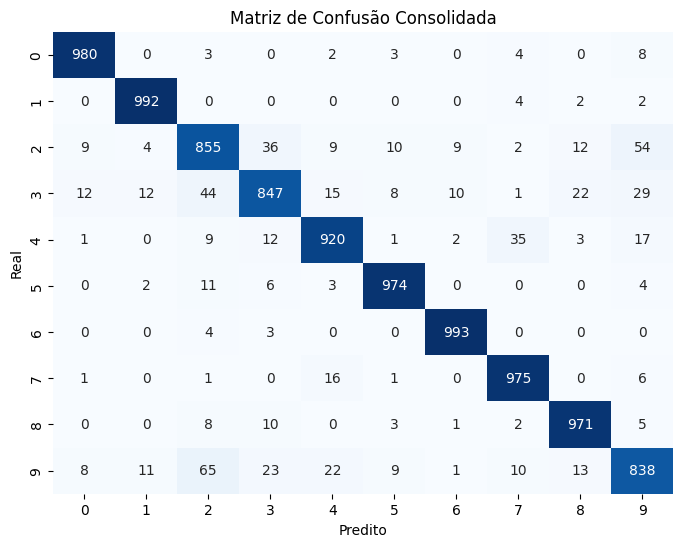

In [68]:
# Matriz 
consolidated_cm = np.sum(all_confusion_matrices, axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(consolidated_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão Consolidada')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

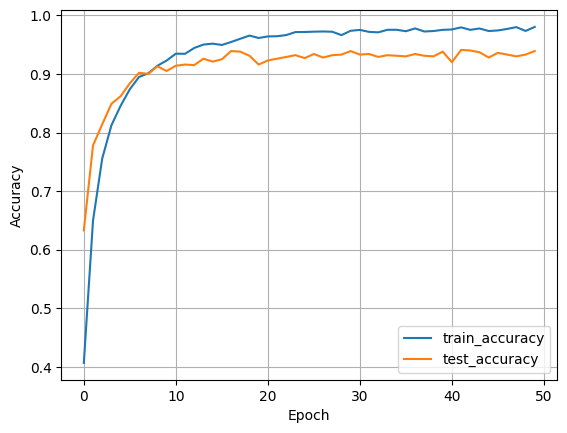

In [69]:
metrics = history.history

plt.plot(metrics['accuracy'], label='train_accuracy')
plt.plot(metrics['val_accuracy'], label='test_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.savefig("accuracy")
plt.show()

Os resultados do treino e avaliação da rede neural 1D (CNN) são bastante promissores. A média da accuracy nos dados de treino atingiu um valor muito alto, aproximando-se de 1, indicando que o modelo se ajustou muito bem aos dados de treino. Além disso, o desvio padrão baixo nessa métrica sugere que o desempenho do modelo foi consistente nas diferentes dobras do k-fold.

No caso dos dados de teste, a média da accuracy permaneceu elevada, atingindo 0.9345, indicando que o modelo está a generalizar bem para dados não vistos. O desvio padrão relativamente baixo na accuracy de teste sugere consistência nas diferentes dobras do k-fold, reforçando a robustez do modelo.

A análise visual das curvas de treino e teste, que são muito parecidas, também é encorajadora, uma vez que a semelhança entre essas curvas sugere que o modelo está a aprender de maneira geral e não está a sofrer de overfitting significativo.

### Comparação das Redes

#### Accuracy no treino

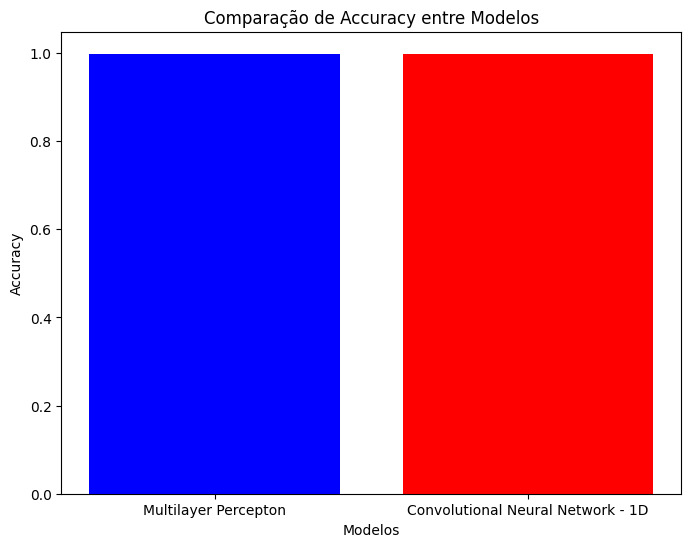

In [146]:
model_names = ['Multilayer Percepton', 'Convolutional Neural Network - 1D']
accuracies = [np.mean(train_accuracy), mean_train_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'red'])


plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.title('Comparação de Accuracy entre Modelos')

plt.show()

#### Accuracy no teste

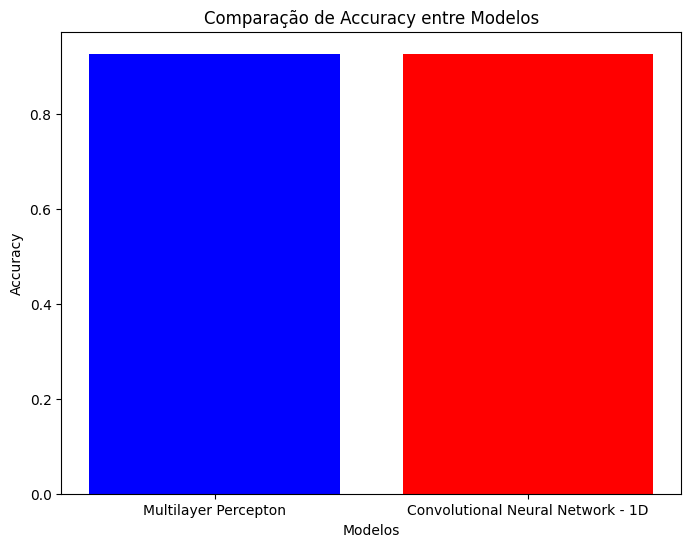

In [147]:
model_names = ['Multilayer Percepton', 'Convolutional Neural Network - 1D']
accuracies = [np.mean(test_accuracy), mean_test_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'red'])


plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.title('Comparação de Accuracy entre Modelos')

plt.show()

## Conclusões Finais

A comparação entre os modelos MLP (Multilayer Perceptron) e CNN 1D (Convolutional Neural Network 1D) no problema de classificação de urban sounds revelou resultados distintos, oferecendo insights valiosos sobre o desempenho de cada abordagem.

O modelo MLP demonstrou um desempenho notável durante o treino, atingindo uma média de precisão de 99,84% com uma pequena variação, indicando uma capacidade robusta de aprender os padrões presentes nos dados de treinamento. No entanto, ao avaliar o modelo em dados de teste, observamos uma precisão média ligeiramente inferior, 92,71%, indicando uma possível tendência de overfitting ligeiro. O desvio padrão de 0,0089 na precisão de teste sugere uma variação significativa nas métricas de desempenho em diferentes divisões dos dados de teste, o que pode ser um ponto de atenção em relação à generalização do modelo.

Por outro lado, o modelo CNN 1D apresentou uma média de precisão de treinamento de 99,69%, com um desvio padrão de 0,0011, indicando consistência na aprendizagem dos padrões durante o treinamento. Ao avaliar o modelo nos dados de teste, observamos uma precisão média ligeiramente inferior, 93,45%, sugerindo uma capacidade comparável de generalização em comparação com o MLP. O desvio padrão de 0,0069 na precisão de teste indica uma variação moderada nas métricas de desempenho, mas ainda dentro de limites aceitáveis.

Ambos os modelos demonstraram habilidade em lidar com o problema de classificação, alcançando precisões notáveis tanto no treino quanto nos dados de teste. No entanto, a CNN 1D parece apresentar uma melhor capacidade de generalização, dado que a sua precisão média de teste é ligeiramente superior e o desvio padrão é mais moderado em comparação com o MLP.

Em resumo, embora o MLP tenha se destacado no treino, a CNN 1D mostrou-se mais equilibrada em termos de desempenho entre treino e teste, indicando potencial para uma melhor capacidade de generalização no contexto do problema.